# Provando ad implementare il codice di un articolo

- [Ispirazione](https://paperswithcode.com/paper/deep-learning-for-ecg-segmentation): PapersWithCode
- [Paper](https://arxiv.org/pdf/2001.04689.pdf): Deep Learning for ECG Segmentation
- [Dataset](https://physionet.org/content/ludb/1.0.1): Lobachevsky University Electrocardiography Database
- [Altro Notebook](https://www.kaggle.com/yschii/find-ecg-wave): My Kaggle



## Dependencies

In [1]:
# first of all install necessary packages
# wfdb usefull for reading ECG data
%pip install -U wfdb
# usefull for machine learning
%pip install -U scikit-learn tensorflow matplotlib pandas
# set matplotlib to plot in the notebook
%matplotlib inline

Requirement already up-to-date: wfdb in c:\users\scala\lang\lib\site-packages (3.4.1)



You should consider upgrading via the 'C:\Users\scala\lang\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\scala\lang\python.exe -m pip install --upgrade pip' command.


Requirement already up-to-date: scikit-learn in c:\users\scala\lang\lib\site-packages (1.0.2)
Requirement already up-to-date: tensorflow in c:\users\scala\lang\lib\site-packages (2.7.0)
Requirement already up-to-date: matplotlib in c:\users\scala\lang\lib\site-packages (3.5.1)
Requirement already up-to-date: pandas in c:\users\scala\lang\lib\site-packages (1.3.5)



In [2]:
# then import necessary packages
import wfdb
from os.path import exists as file_exists
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1DTranspose, BatchNormalization, Activation, Conv1D, ZeroPadding1D, MaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical

tf.config.run_functions_eagerly(False)



## Explore some data

As described in the paper, each ecg has 12 leads, is long 10seconds and since it s sampled at 500hz it has 5000 samples


Fisrt set some constants usefull along the code

There 4 constants
 - leads of the ecg
 - location of the data
 - some colors for plotting
 - the size of the ECG the model is fed with

In [3]:
# since the paper handles 12 lead ECG data, i will use 12 leads
LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
DATA_FOLDER = "./lobachevsky-university-electrocardiography-database-1.0.1/data"
SEGMENT_TO_COLOR = {
    'p': 'red',
    'N': 'blue',
    't': 'green',
}
ECG_SIZE = 41*16 # -> 32*16 = 512


Then some function useful to plot and manipulate the ECGs

In [4]:
from typing import Union,List, Tuple

# get signal with wfdb library
# using an index
def get_signal(index:int, as_p_signal:bool=True) -> Union[wfdb.Record, np.ndarray]:
    record = wfdb.rdrecord(DATA_FOLDER + "/" +  str(index))
    assert type(record) is wfdb.Record

    if as_p_signal:
        assert type(record.p_signal) is np.ndarray
        return record.p_signal
        
    return record

# get annotations given the ecg lead
def get_annotations(index:int, lead, as_sample=True) -> Union[wfdb.Annotation, np.ndarray]:
    annotations = wfdb.rdann(DATA_FOLDER +"/" + str(index), extension = lead)
    if as_sample:
        return np.array(annotations.sample)
    return annotations

# get a full EGC with 12 leads
def get_full_ecg(index:int):
    signal = get_signal(index)
    annotations = [
        get_annotations(index, lead) for lead in LEADS
    ]
    return signal, annotations


def get_single_lead_ecg(index, lead) -> Tuple[np.ndarray, np.ndarray]:
    """
    return and ecg signal and its annotations
    both as ndarray
    """
    signal = get_signal(index)
    assert type(signal) is np.ndarray
    signal = signal[:, LEADS.index(lead)]

    samples = get_annotations(index, lead)
    assert type(samples) is np.ndarray
    
    return signal, samples


def get_annotations_symbols(index, lead):
    ann = get_annotations(index, lead, as_sample=False)
    return ann.symbol

def paired_annotation_sample_and_symbol(index, lead):
    annotations_symbols = get_annotations_symbols(index, lead)
    annotations_sample = get_annotations(index, lead)
    return zip(annotations_sample, annotations_symbols)


def get_single_lead_ecg_with_symbols(index, lead):
    """
    return and ecg signal and its annotations
    both as ndarray
    """
    signal = get_signal(index)
    assert type(signal) is np.ndarray
    signal = signal[:, LEADS.index(lead)]

    data = paired_annotation_sample_and_symbol(index, lead)
    
    return signal, np.array(list(data))

# plot single lead ecg with annotations
def plot_single_lead_ecg(index, lead):
    signal, samples = get_single_lead_ecg(index, lead)

    fig, ax = plt.subplots(figsize = (28, 3))

    ax.plot(signal)
    ax.scatter(samples, signal[samples], c = 'r', marker = 'o')


# now plot every lead with annotations
def plot_signal_with_annotation(index):
    signal, samples = get_full_ecg(index)
    # extract sample from annotations
    wfdb.plot_items(signal, samples )



Every lead is divided in 3 parts
 - the signal `[0.32, 0.454, 0.112, 0.461, 0.28]`
 - the annotation `['(', 'p', ')', '(']`
 - the time points at wich annotation are registered `[2, 5, 11, 15]` like index for the signal

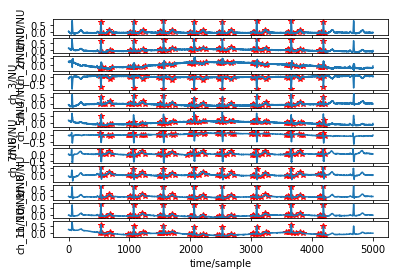

In [45]:
plot_signal_with_annotation(index = 199)   

Still, the ECGs are a bit hard to handle, so i write a class to handle them.

In [46]:
"""
Generator that allows to iterate over a list, grouping the elements in groups of n.
Example:
    >>> list(grouped([1,2,3,4,5,6,7,8,9], n=3))
    [(1, 2, 3), (4, 5, 6), (7, 8, 9)]
"""
def grouped(itr, n=3):
    itr = iter(itr)
    end = object()
    while True:
        vals = tuple(next(itr, end) for _ in range(n))
        if vals[-1] is end:
            return
        yield vals

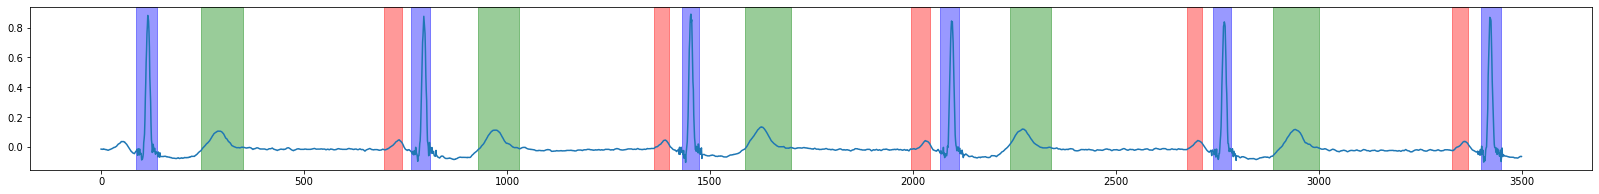

In [47]:
class EGCSignal:
    """
    This class has 4 main purposes:
    1. To store the signal and its annotations
    2. To cut the signal once at the beginning and once at the end
    3. To plot the ECG in different ways
    4. To convert the annotation in a one hot encoding

    Note that doesn't store the entire ECG, but only one lead

    Also has a method to initialize the class without explicitly passing the signal and annotations
    but with the index and lead of the record
    """
    def __init__(self, signal, time_points, symbol, categories = None):
        self.signal:np.ndarray = signal
        self.time_points:np.ndarray = time_points
        self.symbols:list[str] = symbol
        self.symbol_to_category = {
            'N': 0,
            't': 1,
            'p': 2
        }
        self.category_to_symbol = {
            0: 'N',
            1: 't',
            2: 'p'
        }
        self.categories = categories if categories is not None else self.symbols_to_category()
        self._cut_beginning( 550)
        self._cut_end( 3500)

    def __getitem__(self, key):
        return self.signal[key]

    def __len__(self):
        return len(self.signal)

    def _cut_beginning(self, start_point):
        self.signal = self.signal[start_point:]
        self.categories = self.categories[start_point:]

        # now have to check if time_points and symbols are also to cut
        if start_point > self.time_points[0]:
            # get the index of the first time point greater than start_point
            index = np.argmax(self.time_points > start_point)                
            self.time_points = self.time_points[index:]
            self.symbols = self.symbols[index:]

        self.time_points = self.time_points - start_point

        # check the cut point
        if self.categories[0] != -1:
            # if the first symbol is a ')' then i have to prepend a '(' and a letter from self.category_to_symbol
            if self.symbols[0] == ')':
                self.symbols = ['('] + [self.category_to_symbol[self.categories[0]]] + self.symbols
                self.time_points = np.concatenate(([0,1], self.time_points))
            elif self.symbols[0] in self.symbol_to_category:
                # just prepend '('
                self.symbols = ['('] + self.symbols
                self.time_points = np.concatenate(([0], self.time_points))

    def _cut_end(self, end_point):
        self.signal = self.signal[:end_point]
        self.categories = self.categories[:end_point]

        index = self.time_points[self.time_points < self.signal.size].size
        self.time_points = self.time_points[:index]
        self.symbols = self.symbols[:index]

        # check the cut point
        if self.categories[-1] != -1:
            # if the last symbol is a '(' then i have to append a ')' and a letter from self.category_to_symbol
            if self.symbols[-1] == '(':
                self.symbols = self.symbols +  [self.category_to_symbol[self.categories[-1]]] + [')']
                self.time_points = np.concatenate((self.time_points, [self.signal.size - 1, self.signal.size ]))
            elif self.symbols[-1] in self.symbol_to_category:
                # just append ')'
                self.symbols = self.symbols + [')']
                self.time_points = np.concatenate((self.time_points, [self.signal.size]))
 
    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize = (28, 3))
        ax.plot(self.signal)

    def plot_with_time_point(self):
        fig, ax = plt.subplots(figsize = (28, 3))
        self.plot(ax)
        ax.scatter(self.time_points, self.signal[self.time_points], c = 'r', marker = 'o')

    def plot_with_segments(self):
        fig, ax = plt.subplots(figsize = (28, 3))
        self.plot(ax)

        for start, symbol, end in grouped(self.time_points, 3):            
            i = np.nonzero(self.time_points == symbol)[0][0]
            current_symbol = self.symbols[i]
            color = SEGMENT_TO_COLOR[current_symbol]
            ax.axvspan(start, end, color=color, alpha=0.4)

    def symbols_to_category(self):
        """
        converts the symbols list in a numpy array of integers
        same length as the signal
        """

        # first instantiate an array of -1 same length as the signal
        category = np.full(len(self.signal), -1)
        # now fill the array with the known category
        for section in grouped(self.time_points):
            # unpack the section
            start, peak, end = section
            
            
            # get the category given the peak
            i = np.nonzero(self.time_points == peak)[0][0]
            current_symbol = self.symbols[i]

            category[start:end] = self.symbol_to_category[current_symbol]

        return category

    @staticmethod
    def from_index_and_lead(index, lead):
        return EGCSignal(
        get_signal(index)[:, LEADS.index(lead)],
        get_annotations(index, lead),
        get_annotations_symbols(index, lead) )



EGCSignal.from_index_and_lead(1, LEADS[0]).plot_with_segments()


## Dateset preprocessing

Now i use the ECG class to cut parts of the dataset and create the train/test set

For some reasons, a few hundreds of signals are not correctly loaded.

The full dataset will be:
```
200 * 12 * 4 = 9600
9600 - ~200 => 9400 (still a large dataset, i will not dig in to why some ECGs are not loaded)
```


In [8]:
import random
import copy


X = []
Y = []
for ecg_index in range(1,200):
    print(ecg_index, end = ', ')
    for lead in LEADS:
        try:
            start = 0
            s = EGCSignal.from_index_and_lead(ecg_index, lead)
            for ecg_part in range(0, 4):
                s_copy = copy.deepcopy(s)

                span = ECG_SIZE
                start += random.randint(0, 30) + span
                s_copy._cut_beginning(start)
                s_copy._cut_end(span)

                # append the signal to X, also adding a new dimension
                X.append(s_copy.signal)
                # append the category to Y
                Y.append(to_categorical(s_copy.categories + 1, num_classes = 4).astype(np.float32))
        except:
            pass


1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 

## Model Creation and Train

The model is described as a 1-dimentional UNet

In [48]:

"""
To simplify the model i m creating some custom layers

 - the ConvPassLayer to make a convolution with the appropriate padding and activation as described in the paper
 - DownPassLayer to make a max pooling and 2 convolutions
 - UpPassLayer which makes a 'deconvolution', concatenates with same-height layer and makes 2 conv

"""
class ConvPassLayer(layers.Layer):
    def __init__(self, n_conv_filters, activation='relu', padding_size = 4, **kwargs):
        super(ConvPassLayer, self).__init__(**kwargs)
        # parameters
        self.n_conv_filters = n_conv_filters
        self.activation = activation
        self.padding_size = padding_size
        # layers
        self.zero_padding = ZeroPadding1D(padding=self.padding_size)
        self.conv = Conv1D(filters = self.n_conv_filters, kernel_size = 9)
        self.batch_norm = BatchNormalization()
        self.activation_layer = Activation(self.activation)

    def build(self, input_shape):
        self.input_layer = input_shape

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_conv_filters": self.n_conv_filters,
            "activation": self.activation,
            "padding_size": self.padding_size
        })
        return config

    def call(self, x):
        # apply 4 padding in 1 dimension
        pad1 = self.zero_padding(x)
        # apply a convolution with kernel size 9
        conv1 = self.conv(pad1)
        # apply batch normalization
        bn1 = self.batch_norm(conv1)
        # apply activation function
        act1 = self.activation_layer(bn1)
        return act1

    def compute_output_shape(self, input_shape):
        return input_shape

class DownPassLayer(layers.Layer):
    def __init__(self, n_conv_filters, activation='relu', padding_size = 4, **kwargs):
        super(DownPassLayer, self).__init__(**kwargs)
        # parameters
        self.n_conv_filters = n_conv_filters
        self.activation = activation
        self.padding_size = padding_size
        # layers
        self.max_pool = MaxPooling1D(pool_size = 2)
        self.conv_pass_layer1 = ConvPassLayer(self.n_conv_filters, self.activation, self.padding_size)
        self.conv_pass_layer2 = ConvPassLayer(self.n_conv_filters, self.activation, self.padding_size)

    def build(self, input_shape):
        self.input_layer = input_shape

    def call(self, x):
        x = self.max_pool(x)
        x = self.conv_pass_layer1(x)
        x = self.conv_pass_layer2(x)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape//2
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "n_conv_filters": self.n_conv_filters,
            "activation": self.activation,
            "padding_size": self.padding_size
        })
        return config

class UpPassLayer(layers.Layer):
    def __init__(self, n_conv_filters, activation='relu', padding_size = 4, **kwargs):
        super(UpPassLayer, self).__init__(**kwargs)
        # parameters
        self.n_conv_filters = n_conv_filters
        self.activation = activation
        self.padding_size = padding_size
        # layers
        # applys two convolution and pooling layers
        self.deconv = Conv1DTranspose(filters = self.n_conv_filters, kernel_size = 8, strides = 2, padding = 'same')
        self.concat = Concatenate()
        self.conv_pass_layer1 = ConvPassLayer(self.n_conv_filters//2, self.activation, self.padding_size)
        self.conv_pass_layer2 = ConvPassLayer(self.n_conv_filters//2, self.activation, self.padding_size)

    def build(self, input_shape):
        self.input_layer = input_shape

    def call(self, same_layer, lower_layer):
        deconv = self.deconv(lower_layer)
        conc = self.concat([same_layer, deconv])
        conv1 = self.conv_pass_layer1(conc)
        conv2 = self.conv_pass_layer2(conv1)
        
        return conv2



    def get_config(self):
        config = super().get_config()
        config.update({
            "n_conv_filters": self.n_conv_filters,
            "activation": self.activation,
            "padding_size": self.padding_size
        })
        return config


def UNET(inpusize =ECG_SIZE):
    # first block
    inputs = Input((inpusize, 1))
    block1layer1 = ConvPassLayer(4)(inputs)
    block1layer2 = ConvPassLayer(4)(block1layer1)

    # convolution blocks
    block2layer2 = DownPassLayer(8)(block1layer2)
    block3layer2 = DownPassLayer(16)(block2layer2)
    block4layer2 = DownPassLayer(32)(block3layer2)

    # 'bottleneck' layer
    pool4 = MaxPooling1D(2)(block4layer2)
    block5layer1 = ConvPassLayer(64)(pool4)
    block5layer2 = ConvPassLayer(64)(block5layer1)

    # deconv and concatenation
    block4up = UpPassLayer(64)(block4layer2, block5layer2)
    block3up = UpPassLayer(32)(block3layer2, block4up)
    block2up = UpPassLayer(16)(block2layer2, block3up)

    # final block
    transposed1 = Conv1DTranspose(filters = 8, kernel_size = 8, strides = 2, padding = 'same')(block2up)
    block1layer3 = Concatenate()([transposed1, block1layer2])
    block1layer4 = ConvPassLayer(4)(block1layer3)
    block1layer5 = ConvPassLayer(4, activation='softmax')(block1layer4)

    # create model
    return Model(inputs, block1layer5)

# just plot model and a prediction
# to check that layer sizes matches
m = UNET()
m.summary()
print(f"""
{m.predict(X[0].reshape(1, ECG_SIZE, 1))[0]}
""")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 656, 1)]     0           []                               
                                                                                                  
 conv_pass_layer_30 (ConvPassLa  (None, 656, 4)      56          ['input_2[0][0]']                
 yer)                                                                                             
                                                                                                  
 conv_pass_layer_31 (ConvPassLa  (None, 656, 4)      164         ['conv_pass_layer_30[0][0]']     
 yer)                                                                                             
                                                                                            

Now the program load the model if already saved (also test-set is loaded)

If the model is not saved (present in the current direcory) than a new one is going to be trained and saved

In [10]:
# check if the model is already in the direcotry
saved_model_name = f"trained_model_{ECG_SIZE}.h5"
if file_exists(saved_model_name):
    model = load_model(saved_model_name,
        custom_objects={
            'ConvPassLayer': ConvPassLayer,
            'DownPassLayer': DownPassLayer,
            'UpPassLayer': UpPassLayer
            }
    )
    X_test = np.load(f"X_test_{ECG_SIZE}.npy")
    Y_test = np.load(f"Y_test_{ECG_SIZE}.npy")
    print(f"Loaded model from {saved_model_name}")
    print(f"Test accuracy: {model.evaluate(X_test, Y_test)}")
else:

    m = UNET()

    # create an optimizer
    opt = Adam(learning_rate=0.0005)
    m.compile(optimizer=opt, loss='binary_crossentropy') 

    # split the data in train and test
    X_train, X_test, Y_train, Y_test = train_test_split(
        np.array(X),#X,
        np.array(Y, dtype=np.float32),#Y,
        test_size=0.31)

    train_history = m.fit(
        X_train, Y_train,
        epochs=15,
        batch_size=8,
        validation_data=(X_test, Y_test)
    )

    m.save( # https://www.tensorflow.org/guide/keras/save_and_serialize
        f"trained_model_{ECG_SIZE}.h5"
    )
    np.save(f"X_test_{ECG_SIZE}.npy", X_test)
    np.save(f"Y_test_{ECG_SIZE}.npy", Y_test)

    plt.figure()
    plt.plot(train_history.history["loss"], label="train loss")
    plt.plot(train_history.history["val_loss"], label="val loss")



Loaded model from trained_model_656.h5
92/92 [==============================] - 9s 72ms/step - loss: 0.1112
Test accuracy: 0.11124581843614578


## Measurements

Model scorec can be quite tricky to measure and the papar is not very detailed on how to handle certain situation, i took a simple approach... probably not the same, but quite close.


```
Frequenza ecg nel dataset = 500hz
-> 500campioni/sec
-> 5camp/10ms (5campioni durano un tempo di 10ms)
-> 1passo = 2ms 
-> 75 campioni coprono un arco di 150ms

Se la distanza tra l'annotazione del modello e quella del dottore non distano piu di 75 valori
allora posso dire che il modello ha annotato bene

TP = tutti quelli nella tolleranza (75campioni)
FP = se l'algoritmo annota, ma non c'è nulla (di annotato) nella tolleranza
FN = se l algoritmo non annota ma c'è qualcosa

Per ogni tipologia di onda
    Per ogni onda nei dati
        per ogni onset/offset
            per ogni onda
                media e std dev
                recall = TP/(TP + FN)
                precision= TP/(TP + FP)
                f1 = 2 * (recall*precision) / (recall+precision) 

```

C'è però un problema, per quanto il modello sia adestrato si dati che presentatno le wave come contigue, io non ho garanzie che lo siano effettivamente anche nella previsione (perche ne ione il paper facciamo post processing, per esemio per cancellare i segmenti palesemente troppo corti). Questo significa che la previsione del modello potrebbe essere piena di mini-wave chiaramente errori che però io devo contare come Falsi Positivi o Falsi Negativi. Esempio: c'è un ecg che ha il complesso QRS tra il tempo 100 (onset) e il 150 (offset); la previsione identifica però due onde QRS, una tra 90 e 110, l'altra tra 140 e 150, diventa tosto decidere quale onda considerare quella che realmente rappresenta la realtà

In [11]:
Y_test_pred = model.predict(X_test)
toll = 75

In [43]:
def find_wave_onset(wave_category:list) -> np.ndarray:
    onsets = []
    prev = None
    for i, val in enumerate(wave_category):
        if val != 0 and prev == 0:
            onsets.append(i)
        prev = val
    return np.array(onsets)

def find_wave_offset(wave_category:list) -> np.ndarray:
    offsets = []
    prev = None
    for i, val in enumerate(wave_category):
        if val == 0 and prev != 0:
            offsets.append(i)
        prev = val
    return np.array(offsets)

def get_probably_matching_timepoints(shorter:np.ndarray, longer:np.ndarray):
    indices_minimizind_distancies = [
        np.argmin(row) for row in np.abs(np.subtract.outer(shorter, longer))
    ]
    return longer[indices_minimizind_distancies]


def get_true_false_errs_from_mismatching_timepoints(shorter:np.ndarray, longer:np.ndarray, toll:int):
    if len(shorter) == 0:
        return len(longer), 0, []

    falses = len(longer) - len(shorter)

    matched_longer = get_probably_matching_timepoints(shorter, longer)

    dists = np.abs(matched_longer - shorter)

    trues = np.sum(dists <= toll)
    errs = list(dists[dists < toll])

    return falses, trues, errs 


WAVE_TO_COLUMN = {
    "None": 0,
    "P":3,
    "QRS":1,
    "T":2,
}

WAVE_DATA = {
    "None": None,
    "P": {},
    "QRS": {},
    "T": {},
}



for wave_name, column_index in WAVE_TO_COLUMN.items():
    if column_index == 0:
        continue
    print("checking", wave_name)
    for phase, time_point_function in zip(["onset", "offset"],[find_wave_onset, find_wave_offset]):

        evaluation = {
            "TP": 0,
            "FP": 0,
            "FN": 0,
            "errors": [],
            "mean_iou": MeanIoU(num_classes=4)
        }

        for y_test, y_pred in zip(Y_test, Y_test_pred):
            wave_test = (np.argmax(y_test, axis=1) == column_index).astype(int)
            wave_pred = (np.argmax(y_pred, axis=1) == column_index).astype(int)

            wave_test_points = time_point_function(wave_test)
            wave_pred_points = time_point_function(wave_pred)
            try:
                if len(wave_test_points) == len(wave_pred_points):
                    # i ASSUME that wave match and that there might be true positives
                    # still have to if correspoding points are in the tollerance
                    _, trues, errs = get_true_false_errs_from_mismatching_timepoints(wave_test_points, wave_pred_points, toll)
                    evaluation["TP"] += trues
                    evaluation["errors"] += errs
                    
                elif len(wave_test_points) > len(wave_pred_points):
                    # if 'wave_test_points' is longer i have false negatives
                    falses, trues, errs = get_true_false_errs_from_mismatching_timepoints(wave_pred_points, wave_test_points, toll)
                    evaluation["TP"] += trues
                    evaluation["FN"] += falses
                    evaluation["errors"] += errs

                elif len(wave_test_points) < len(wave_pred_points):
                    # if 'wave_pred_points' is longer i have false positives
                    falses, trues, errs = get_true_false_errs_from_mismatching_timepoints(wave_test_points, wave_pred_points, toll)

                    evaluation["TP"] += trues
                    evaluation["FP"] += falses
                    evaluation["errors"] += errs
            except Exception as e:
                print(wave_test_points, wave_pred_points, len(wave_test_points), len(wave_pred_points))
                raise e


            evaluation["mean_iou"].update_state(wave_test, wave_pred)

        
        WAVE_DATA[wave_name][phase] = evaluation


checking P
checking QRS
checking T


In [44]:
for wave, phase_data in WAVE_DATA.items():
    if wave == "None":
        continue
    else:
        print(f"{wave}")

    for phase, data in phase_data.items():
        err = np.array(data['errors']) * 2
        rec = data['TP']/(data['TP'] + data['FN'])
        prec = data['TP']/(data['TP'] + data['FP']) # TP/(TP + FP)
        miou = data["mean_iou"].result().numpy()
        print(f"""    {phase}
        recall = {round(rec * 100,2)}
        precision = {round(prec * 100,2)}
        {err.mean().round(2)} +- {err.std().round(2)} (ms)
        m_iou = {round(miou * 100, 2)}""" )


P
    onset
        recall = 95.37
        precision = 92.19
        13.62 +- 15.81 (ms)
        m_iou = 85.51
    offset
        recall = 98.58
        precision = 94.75
        6.38 +- 10.81 (ms)
        m_iou = 85.51
QRS
    onset
        recall = 97.75
        precision = 98.12
        6.23 +- 6.66 (ms)
        m_iou = 91.83
    offset
        recall = 99.21
        precision = 98.33
        5.39 +- 8.15 (ms)
        m_iou = 91.83
T
    onset
        recall = 97.45
        precision = 93.01
        18.85 +- 18.83 (ms)
        m_iou = 87.6
    offset
        recall = 98.84
        precision = 94.72
        10.18 +- 17.58 (ms)
        m_iou = 87.6


## Nice plots

Some art 

In [ ]:
ecg_index = 11

Fist the ECG signal with the right annotations 

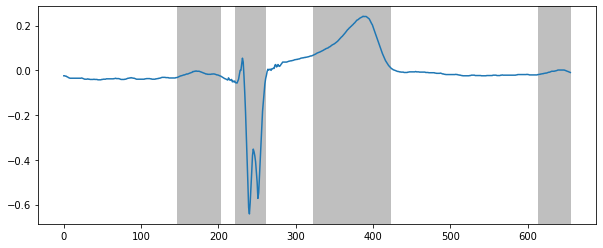

In [14]:
# plot categories on ecg
signal = X_test[ecg_index]
categories = np.argmax(Y_test[ecg_index], axis=1)
predicted_categories = np.argmax(Y_test_pred[ecg_index], axis=1)

# get time point where category changes
time_points = np.where(categories[:-1] != categories[1:])[0]

# chek if category was at beginning or end
if categories[0] != 0:
    # if category was at beginning, add first time point
    time_points = np.append(0, time_points)
if categories[-1] != 0:
    # if category was at end, add last time point
    time_points = np.append(time_points, len(categories))

# plot the signal
plt.figure(figsize=(10, 4))
plt.plot(signal)
for b,e in grouped(time_points, 2):
    plt.axvspan(b, e, facecolor='0.5', alpha=0.5)


And then the same ECG with predicted segmentation

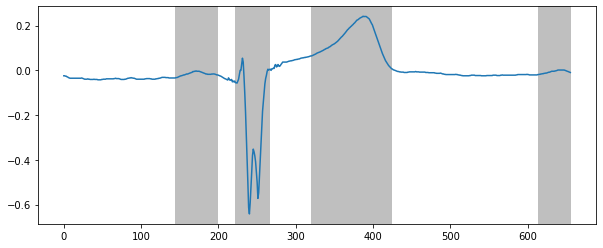

In [15]:

signal = X_test[ecg_index]
categories = np.argmax(Y_test[ecg_index], axis=1)
predicted_categories = np.argmax(Y_test_pred[ecg_index], axis=1)

# get time point where category changes
time_points = np.where(predicted_categories[:-1] != predicted_categories[1:])[0]


# chek if category was at beginning or end
if predicted_categories[0] != 0:
    # if category was at beginning, add first time point
    time_points = np.append(0, time_points)
if predicted_categories[-1] != 0:
    # if category was at end, add last time point
    time_points = np.append(time_points, len(predicted_categories))

# plot the signal
plt.figure(figsize=(10, 4))
plt.plot(signal)
for b,e in grouped(time_points, 2):
    plt.axvspan(b, e, facecolor='0.5', alpha=0.5)



In [16]:
pred = Y_test_pred[ecg_index]

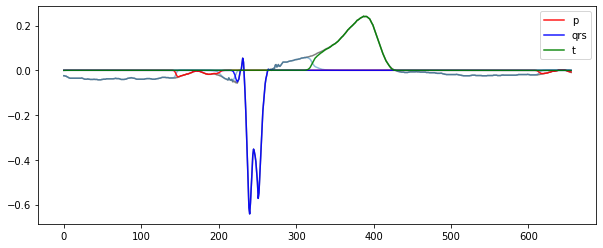

In [50]:
plt.figure(figsize=(10, 4))

plt.plot(signal, color = "gray")
plt.plot(pred[:,0]*signal, alpha=0.5) # predicted not interesting

plt.plot(pred[:,3]*signal, alpha=0.9, label= "p", c=SEGMENT_TO_COLOR['p']) # predicted p

plt.plot(pred[:,1]*signal, alpha=0.9, label= "qrs", c=SEGMENT_TO_COLOR['N']) # predicted qrs
plt.plot(pred[:,2]*signal, alpha=0.9, label= "t", c=SEGMENT_TO_COLOR['t']) # predicted t

plt.legend(
    loc='upper right',
    ncol=1,

)

Lastly, alwasys the same ECG but colored depending on the probability that the model assign to every sample of being of a certainc category

(-0.6420765027322405, 0.24153005464480876)

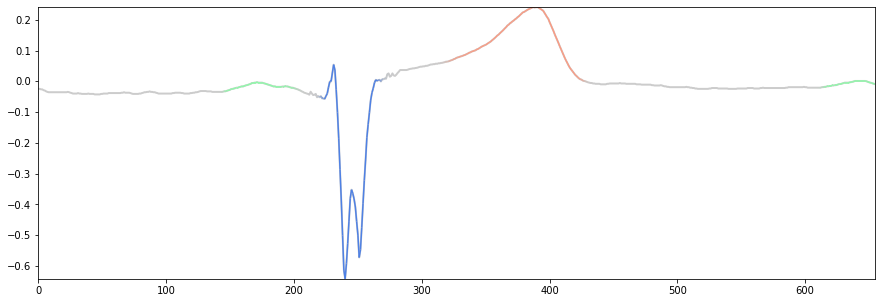

In [18]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

x   = np.arange(len(signal)) 
t = np.linspace(0,1,x.shape[0]) # your "time" variable

lightblue  = [(0.3, 0.5, 0.9, 0.99 * p) for p in pred[:,1]]
lightred   = [(0.99, 0.6, 0.5, 0.99 * p) for p in pred[:,2]]
lightgreen = [(0.55, 0.99, 0.66, 0.99 * p) for p in pred[:,3]]


# set up a list of (x,y) points
points = np.array([x,signal]).transpose().reshape(-1,1,2)
segs = np.concatenate([points[:-1],points[1:]],axis=1)

# make the collection of segments
lcblue = LineCollection(segs, cmap=ListedColormap( lightblue))
lcblue.set_array(t)
lcred = LineCollection(segs, cmap=ListedColormap( lightred))
lcred.set_array(t)
lcgreen = LineCollection(segs, cmap=ListedColormap( lightgreen))
lcgreen.set_array(t)


# plot the collection
plt.figure(figsize=(15, 5))
plt.plot(signal, alpha = 0.4, linewidth = 2, color='gray')
plt.gca().add_collection(lcblue) # add the collection to the plot
plt.gca().add_collection(lcred) # add the collection to the plot
plt.gca().add_collection(lcgreen) # add the collection to the plot
plt.xlim(x.min(), x.max()) # line collections don't auto-scale the plot
plt.ylim(signal.min(), signal.max())

## Differencies

With respect to the original paper

- not sure we used the same dataset
    - the authors used a 455 ECG dataset (they name it "extended LUDB", but i couldn't find the extended version)
- i do not do preprocessing
    - articles's dataset is made indipendent from sample frequency and signal length
- we train the model on different length segment
    - paper takes (from every signal) two 4sec long cuts, I took 4 segments each one 1sec long 
- i did much less experiments to evaluate the model
    - for example: the paper also show results for segmentation quality made just with "II" lead
- i measured TP, FN, FP in a different way
    - the paper is not very detailed on how to handle "complicated" and "inaccurate" prediction, the model can produce both FN and FP in the same prediction and it is hart to account fot that during measurements; the decided to simplify my job making some assumption (eg. if there are the same number of onset/offset the model has no FN/FP, if there are more wave in the true ECG then there are only FN), still results seems to look like the ones on the paper (P wave are ok, QRS most easilly detectd, T wave with largest uncertenty)